In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling2D, Flatten, Dense, Input, Concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('west_coast_tweets.csv')
df.head()

,Timestamp,TweetText,Closest_State,Closest_City,Region
0,82916,going to take a nap join me,California,Adelanto,West Coast
1,84900,lol dork so ur still in cali,California,Adelanto,West Coast
2,86105,ahh euclid off th 60,California,Adelanto,West Coast
3,93,put it on tyra shes giving fat girls a chance...,California,Adelanto,West Coast
4,562,what day is that,California,Adelanto,West Coast


In [4]:
df.shape

(38604, 5)

In [5]:
df['TweetText'] = df['TweetText'].astype(str)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['TweetText'].tolist())

In [7]:
df2 = df.copy()

In [8]:
cols = ['Closest_City','Region']
df2 = df2.drop(cols, axis = 1)

In [9]:
one_hot = pd.get_dummies(df2['Closest_State'])
df2 = df2.join(one_hot)
df2 = df2.drop('Closest_State', axis = 1)

In [10]:
df2

,Timestamp,TweetText,California,Oregon,Washington
0,82916,going to take a nap join me,1,0,0
1,84900,lol dork so ur still in cali,1,0,0
2,86105,ahh euclid off th 60,1,0,0
3,93,put it on tyra shes giving fat girls a chance...,1,0,0
4,562,what day is that,1,0,0
...,...,...,...,...,...
38599,27359,shes got2goshes a sellout 2 crackerscorporofa...,0,0,1
38600,30390,good nightrest well,0,0,1
38601,30754,likewisebut its funi use macromediaadobe stud...,0,0,1
38602,31492,hate2say itbut im poopedbeds lookin awfully ni...,0,0,1


In [11]:
x_dat = df2[['TweetText','Timestamp']]
y_dat = df2[df['Closest_State'].unique()]

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_dat, y_dat, test_size = 0.25, random_state = 40)

In [13]:
x_dat["TweetText"].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.99])

count    38604.000000
mean        12.062584
std          8.382297
min          1.000000
1%           2.000000
50%         11.000000
99%         29.000000
max        644.000000
Name: TweetText, dtype: float64

In [14]:
tmax_length = 29

In [15]:
train_sequences = tokenizer.texts_to_sequences(x_train['TweetText'].tolist())
test_sequences = tokenizer.texts_to_sequences(x_test['TweetText'].tolist())

train_seq = pad_sequences(train_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')
test_seq = pad_sequences(test_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')

In [16]:
vocab_size = len(tokenizer.index_word) + 1
embedding_dim = 150

In [17]:
timestamps_train = x_train['Timestamp']
timestamps_test = x_test['Timestamp']

In [18]:
input_seq = Input(shape = (tmax_length,), name = 'Input Sequence')
input_time = Input(shape = (1,), name = "Input Timestamp")

embed = Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = tmax_length)(input_seq)
convol = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(embed)
maxpool = GlobalAveragePooling1D()(convol)

concat = Concatenate()([maxpool, input_time])
dense1 = Dense(50, activation = 'relu')(concat)
dense2 = Dense(25, activation = 'relu')(dense1)
dense3 = Dense(15, activation = 'relu')(dense2)
output = Dense(len(df['Region'].unique()), activation = 'sigmoid')(dense3)

model = Model(inputs = [input_seq, input_time], outputs = output)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['f1_score'])
#model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['f1_score'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input Sequence (InputLayer)     [(None, 29)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 29, 150)      5643450     Input Sequence[0][0]             
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 27, 128)      57728       embedding[0][0]                  
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 128)          0           conv1d[0][0]                     
______________________________________________________________________________________________

In [19]:
history = model.fit([train_seq, timestamps_train], y_train, epochs = 6, batch_size = 50, validation_data = ([test_seq, timestamps_test], y_test))

Epoch 1/6
541/541 [==============================] - 31s 56ms/step - loss: 35.5384 - accuracy: 0.8098 - val_loss: 11.7270 - val_accuracy: 0.8985
Epoch 2/6
541/541 [==============================] - 30s 56ms/step - loss: 19.3726 - accuracy: 0.8116 - val_loss: 21.6832 - val_accuracy: 0.8960
Epoch 3/6
541/541 [==============================] - 31s 57ms/step - loss: 16.0266 - accuracy: 0.8219 - val_loss: 18.3228 - val_accuracy: 0.8935
Epoch 4/6
541/541 [==============================] - 30s 56ms/step - loss: 12.5286 - accuracy: 0.8382 - val_loss: 16.3161 - val_accuracy: 0.8935
Epoch 5/6
541/541 [==============================] - 30s 55ms/step - loss: 7.9634 - accuracy: 0.8574 - val_loss: 9.6241 - val_accuracy: 0.8606
Epoch 6/6
541/541 [==============================] - 30s 56ms/step - loss: 6.7682 - accuracy: 0.8741 - val_loss: 10.8426 - val_accuracy: 0.8876


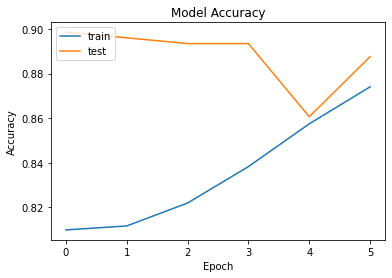

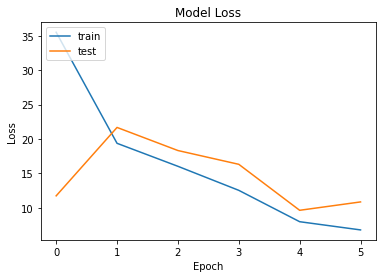

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()